In [57]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier 

In [42]:
%%capture
pip install iterative-stratification

In [43]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [44]:
train = pd.read_csv("/kaggle/input/playground-series-s4e3/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e3/test.csv")

target_cols=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps','Other_Faults']
train = train[train[target_cols].sum(axis=1) == 1]
train.drop(columns=['id'], axis=1, inplace=True)
test.drop(columns=['id'], axis=1, inplace=True)


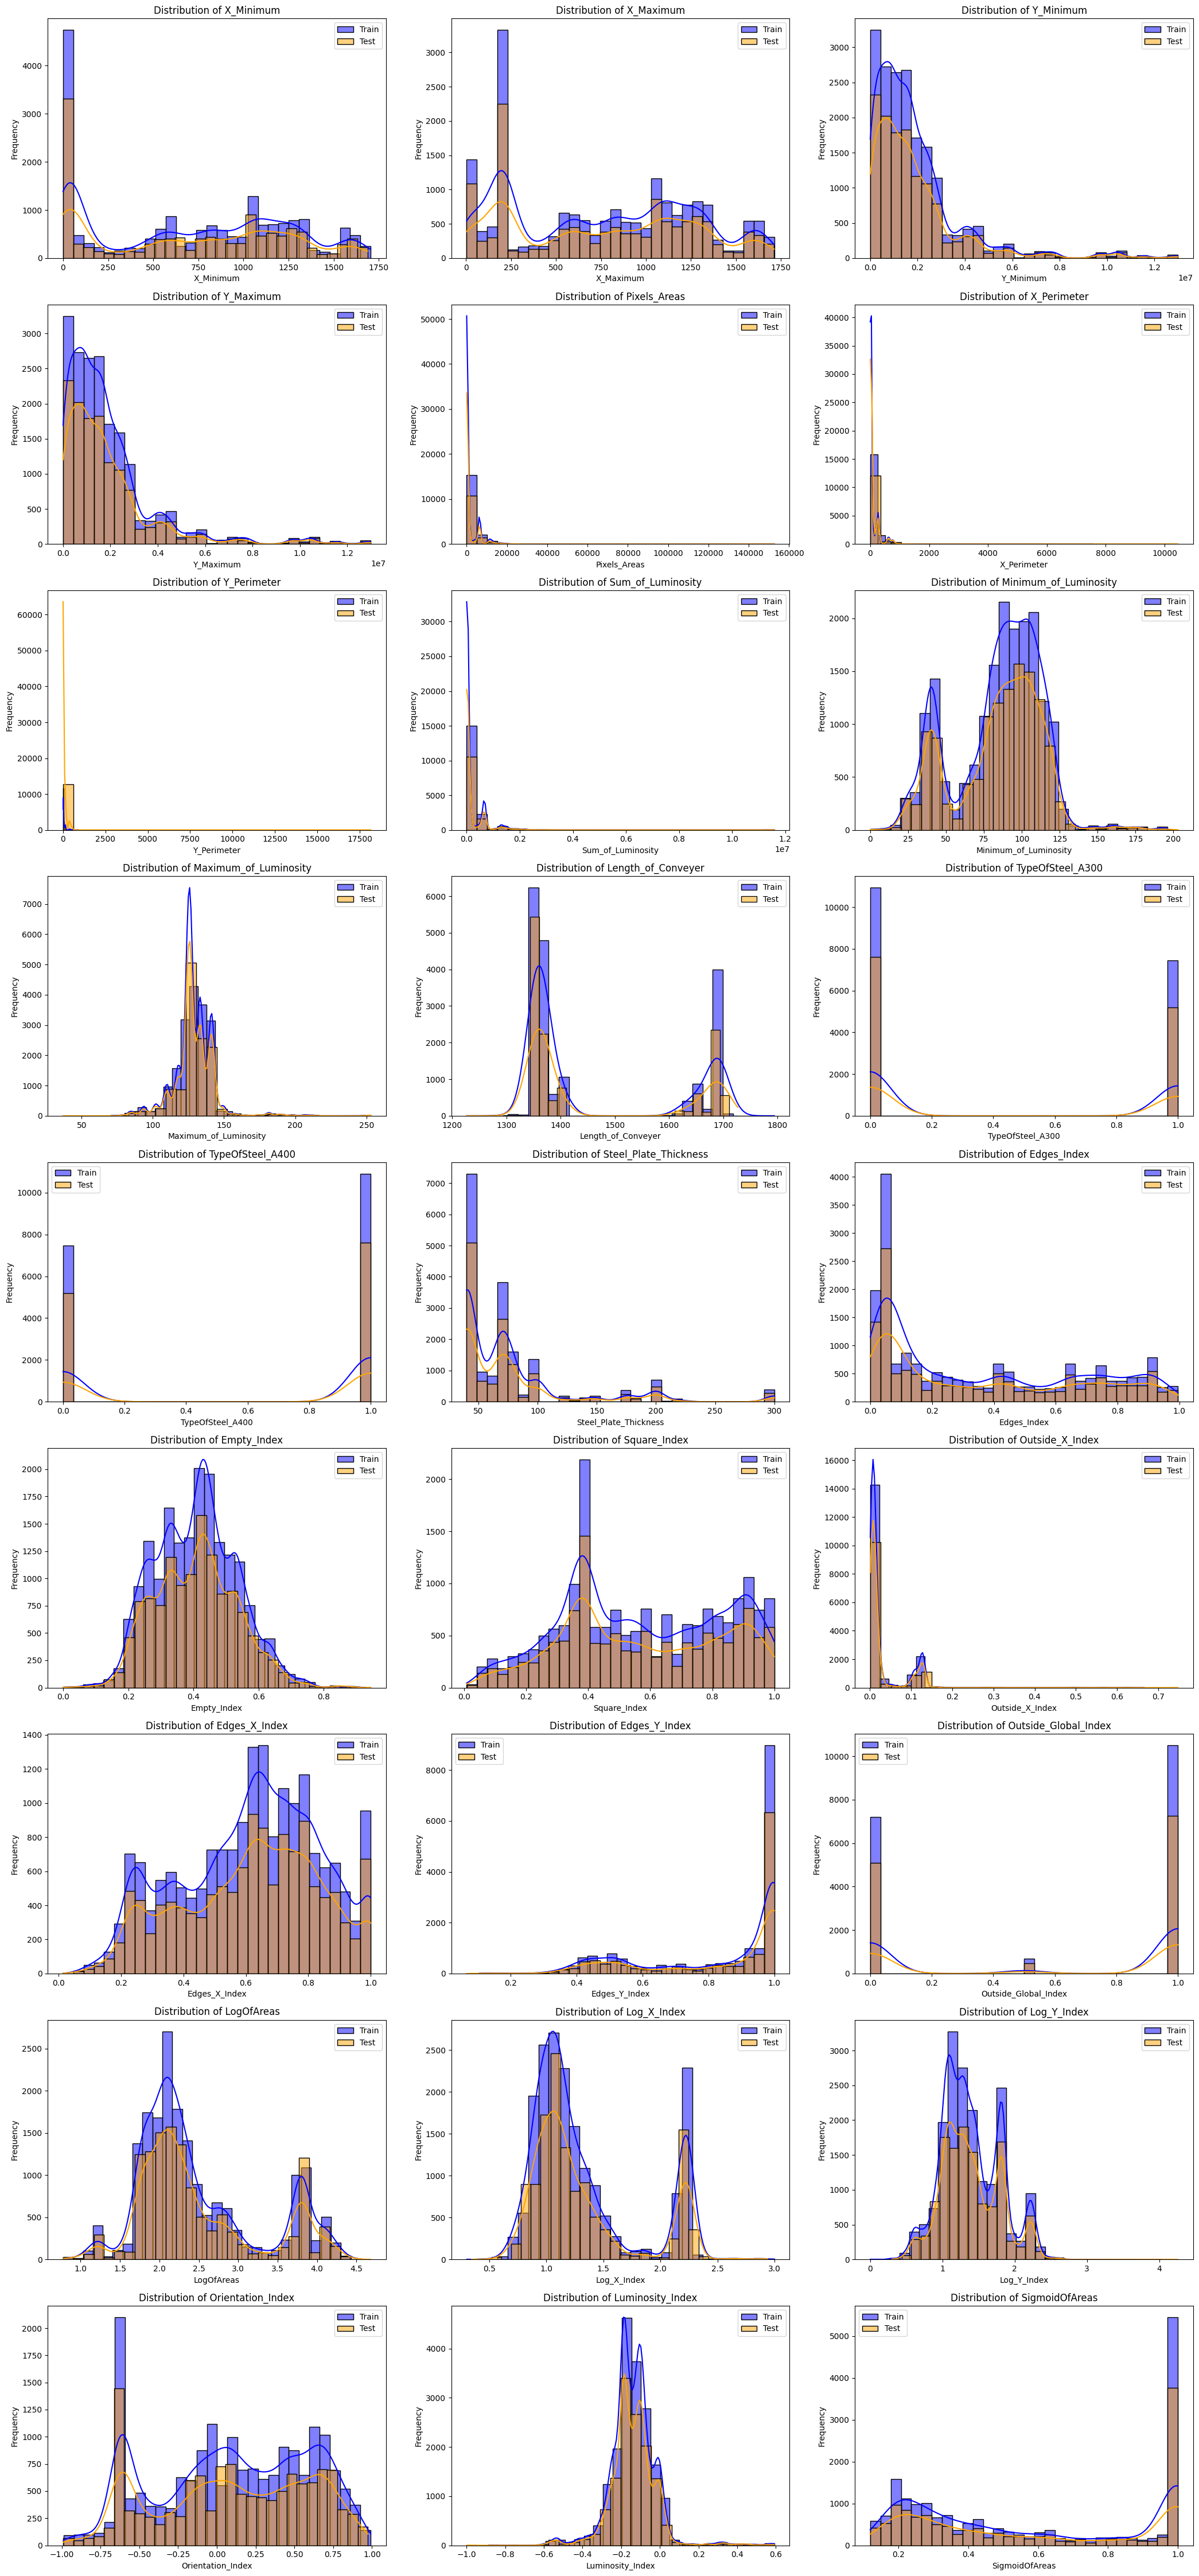

In [45]:
cont_cols = test.columns
colors = ['blue', 'orange', 'green']  

num_plots = len(cont_cols)
num_cols = 3  
num_rows = -(-num_plots // num_cols)  
fig, axes = plt.subplots(num_rows, num_cols, figsize=(21, 5 * num_rows))  # Adjust the figure size as needed

for i, feature in enumerate(cont_cols):
    row = i // num_cols
    col = i % num_cols

    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    sns.histplot(train[feature], kde=True, color=colors[0], label='Train', alpha=0.5, bins=30, ax=ax)
    sns.histplot(test[feature], kde=True, color=colors[1], label='Test', alpha=0.5, bins=30, ax=ax)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()

if num_plots % num_cols != 0:
    for j in range(num_plots % num_cols, num_cols):
        axes[-1, j].axis('off')

plt.tight_layout()
plt.show()

In [46]:
discrete_col = ['TypeOfSteel_A300', 'TypeOfSteel_A400']
continuous_cols = [col for col in X.columns if col not in discrete_col]

# Initialize RobustScaler
scaler = RobustScaler()

# Fit scaler on training data (excluding discrete and target columns)
train_continuous_scaled = scaler.fit_transform(train[continuous_cols])

# Transform both training and testing data using the same scaler
train_scaled = train.copy()
train_scaled[continuous_cols] = train_continuous_scaled

test_scaled = test.copy()
test_scaled[continuous_cols] = scaler.transform(test[continuous_cols])
    

In [48]:
X = train_scaled.drop(columns=target_cols, axis=1)
y = train_scaled[target_cols]

In [52]:

# Initialize your classifier (Random Forest for example)
rf = RandomForestClassifier()

# Initialize MultiOutputClassifier with the base classifier
multi_target_classifier = MultiOutputClassifier(rf)

# Initialize MultilabelStratifiedKFold
kf = MultilabelStratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Iterate over each fold
for train_index, test_index in kf.split(X, y):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the multi-output classifier on the training data
    multi_target_classifier.fit(X_train, y_train)
    
    # Predict on the testing data
    y_pred = multi_target_classifier.predict(X_test)
    
    # Evaluate the classifier on the testing data
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

Accuracy: 0.4028835690968444
Accuracy: 0.40505984766050057
Accuracy: 0.39581066376496193
Accuracy: 0.40043525571273125
Accuracy: 0.4094124047878128


In [94]:
class Modeling:
    """
    Class for fitting multiple models wrapped in MultiOutputClassifier
    using 5 folds with MultilabelStratifiedKFold for multi-label classification.
    Averaging the accuracy score and comparing them in a plot
    Params: 
        models: a dictionary of different ML models
        X: the specified features
        y: the specified targets
    """
    def __init__(self, models: dict, X, y):
        self.models = {name: MultiOutputClassifier(model) for name, model in models.items()}
        self.X = X
        self.y = y
        self.avg_accuracy_score = None
        self.model_avg_scores = None
        self.plot = None
    
    def fit_models(self):
        """Function for fitting and scoring each model over 5 folds"""
        # Initialize MultilabelStratifiedKFold
        kf = MultilabelStratifiedKFold(n_splits=5, random_state=42, shuffle=True)

        # Dictionaries to store average accuracy scores and model average scores
        avg_accuracy_scores = {}
        model_avg_scores = {}

        # Iterate over each model
        for model_name, model in self.models.items():
            print("Training", model_name)

            # List to store accuracy scores for each fold
            fold_accuracy_scores = []

            # Iterate over each fold
            for train_index, test_index in kf.split(self.X, self.y):
                X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
                y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]

                # Fit the model on the training data
                model.fit(X_train, y_train)

                y_preds = model.predict(X_test)

                # Calculate accuracy score for the fold
                accuracy_fold = accuracy_score(y_test, y_preds)

                # Append accuracy score for the fold to the list
                fold_accuracy_scores.append(accuracy_fold)

            # Calculate average accuracy score across folds for the model
            avg_accuracy_score = np.mean(fold_accuracy_scores)

            # Store average accuracy score for the model
            avg_accuracy_scores[model_name] = avg_accuracy_score
            model_avg_scores[model_name] = fold_accuracy_scores

        self.avg_accuracy_scores = avg_accuracy_scores
        self.model_avg_scores = model_avg_scores
        self._plot_scores()
    
    def _plot_scores(self):
        '''Function responsible for plotting'''
        if self.avg_accuracy_scores is None:
            print("Please fit models first using fit_models method.")
            return

        # Plot average accuracy scores for each model
        plt.figure(figsize=(10, 6))
        plt.barh(list(self.avg_accuracy_scores.keys()), list(self.avg_accuracy_scores.values()))
        plt.xlabel('Average Accuracy Score')
        plt.ylabel('Model')
        plt.title('Average Accuracy Score for Different Models')

        # Store the plot as an attribute
        self.plot = plt
    
    def show_plot(self):
        """Show the stored plot"""
        if self.plot is None:
            print("No plot available. Please run fit_models method first.")
            return
        self.plot.show()

Training Gradient Boosting
Training LightGBM
[LightGBM] [Info] Number of positive: 1172, number of negative: 13532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 14704, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.079706 -> initscore=-2.446346
[LightGBM] [Info] Start training from score -2.446346
[LightGBM] [Info] Number of positive: 920, number of negative: 13784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 14704, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062568 -> initscore=-2.706890
[LightGBM] [Info] Start 

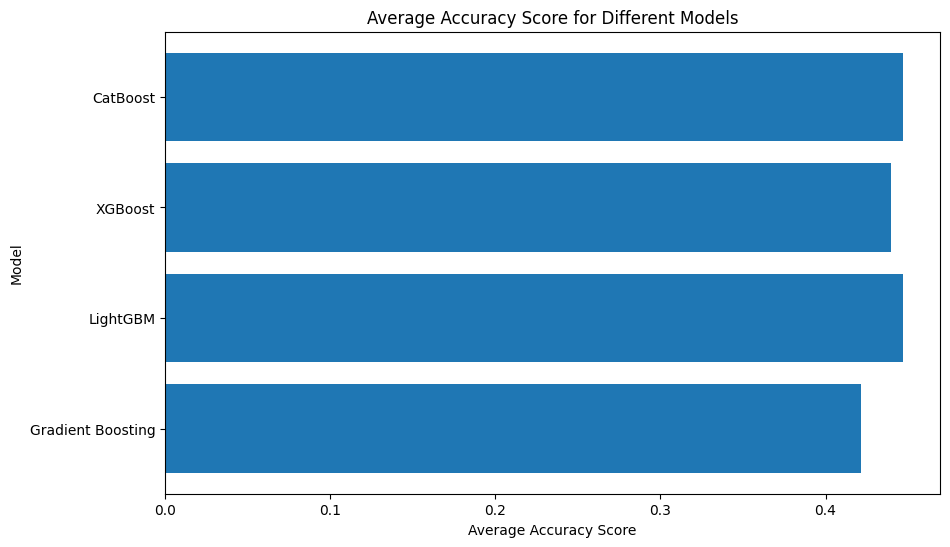

{'Gradient Boosting': [0.42600652883569096,
  0.4246463547334059,
  0.41539717083786726,
  0.41430903155603915,
  0.426550598476605],
 'LightGBM': [0.4507616974972797,
  0.45321001088139284,
  0.4423286180631121,
  0.43879216539717086,
  0.4499455930359086],
 'XGBoost': [0.44613710554951036,
  0.4349836779107726,
  0.43389553862894453,
  0.44069640914036995,
  0.4431447225244831],
 'CatBoost': [0.44613710554951036,
  0.4469532100108814,
  0.44477693144722524,
  0.4485854189336235,
  0.44804134929270945]}

In [95]:
# Define the models dictionary
models = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "LightGBM": LGBMClassifier(objective='binary'),
    "XGBoost": XGBClassifier(objective='binary:logistic'),
    "CatBoost": CatBoostClassifier(silent=True, objective='Logloss')
}

# Instantiate the Modeling class
modeling_instance = Modeling(models, X, y)

# Fit models
modeling_instance.fit_models()

# Show the plot
modeling_instance.show_plot()

# Show the dict of the average accuracy across 5 folds of the models
modeling_instance.avg_accuracy_scores

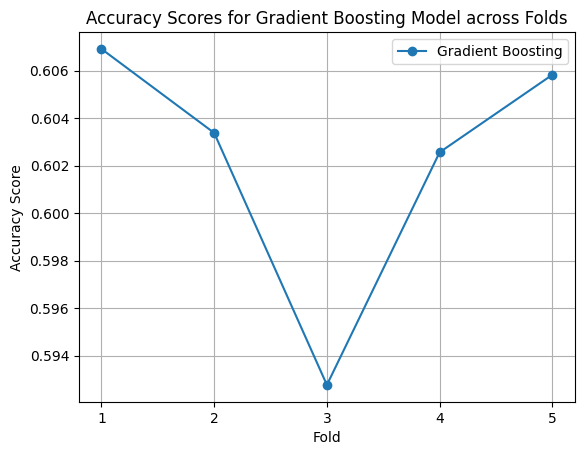

{'Gradient Boosting': [0.6069096844396082, 0.6033732317736671, 0.5927638737758433, 0.6025571273122959, 0.6058215451577802], 'LightGBM': [0.5903155603917302, 0.6063656147986942, 0.5854189336235038, 0.5965723612622416, 0.6011969532100109], 'XGBoost': [0.6006528835690969, 0.5990206746463548, 0.5753536452665942, 0.5878672470076169, 0.5916757344940152], 'CatBoost': [0.6025571273122959, 0.6022850924918389, 0.5897714907508161, 0.5870511425462459, 0.5987486398258978]}


In [111]:
scores = modeling_instance2.model_accuracy_scores

gb_scores = scores['Gradient Boosting']
plt.plot(range(1, len(gb_scores) + 1), gb_scores, marker='o', label='Gradient Boosting')

# Customize plot
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Gradient Boosting Model across Folds')
plt.xticks(range(1, len(gb_scores) + 1))
plt.grid(True)
plt.legend()

# Show plot
plt.show()
print(scores)

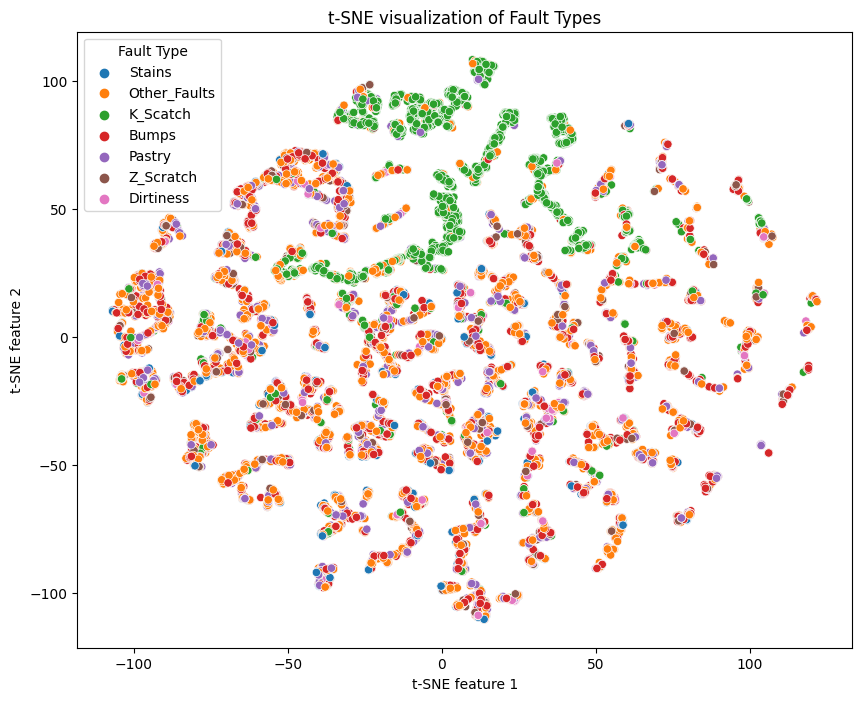

In [5]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train2 = pd.read_csv("/kaggle/input/playground-series-s4e3/train.csv")

target_cols=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps','Other_Faults']
train2['target'] = pd.Series(train2[target_cols].idxmax(axis=1))
# Separating features and labels
X3 = train2.drop(columns=target_cols + ['id', 'target'], axis=1)
y3 = train2['target']

# Performing t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
X_tsne = tsne.fit_transform(X3)

# Creating a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y3, legend='full')
plt.title('t-SNE visualization of Fault Types')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend(title='Fault Type')
plt.show()

In [7]:
!pip install -qq iterative-stratification

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import numpy as np

y4 = train2[target_cols]
X_train, X_test, y_train, y_test = train_test_split(X3, y4)


scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = MultiOutputClassifier(LogisticRegression(max_iter=1000, solver='lbfgs', random_state=24))
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Average ROC AUC score: ", np.mean(cross_val_score(lr, X_train_scaled, y_train, cv=mskf, scoring = "roc_auc")))


Average ROC AUC score:  0.859578233224729


In [20]:
from xgboost import XGBClassifier

params = {
    "objective": "binary:logistic",
    "verbosity": 0,
    "eval_metric": "auc",
    "n_estimators": 714,
    "learning_rate": 0.011780861304968424,
    "max_depth": 5,
    "subsample": 0.9630436649618317,
    "colsample_bytree": 0.2340521143591171,
    "min_child_weight": 2,
}

xgb = MultiOutputClassifier(XGBClassifier(**params))

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Average ROC AUC score: ", np.mean(cross_val_score(xgb, X_train_scaled, y_train, cv=mskf, scoring = "roc_auc")))



Average ROC AUC score:  0.8875732909939705
